In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

import os, glob
import cPickle as pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
RESULTS_DIR = '/n/regal/pfister_lab/PERCEPTION/RESULTS/'
RESULTS_DIR2 = '/n/regal/pfister_lab/PERCEPTION/RESULTS_FROM_SCRATCH/'

In [3]:
from keras.models import load_model
from keras import backend as K


Using TensorFlow backend.


In [4]:
# model_pie1 = load_model(RESULTS_DIR+'C.Figure3.data_to_piechart/VGG19/01_noise.h5')
model_pie2 = load_model(RESULTS_DIR2+'C.Figure3.data_to_piechart/VGG19/10_noise.h5')

In [5]:
import keras.backend as K

#
# CODE BELOW FROM https://github.com/philipperemy/keras-visualize-activations
#
def get_activations(model, model_inputs, print_shape_only=False, layer_name=None):
    print('----- activations -----')
    activations = []
    inp = model.input

    model_multi_inputs_cond = True
    if not isinstance(inp, list):
        # only one input! let's wrap it in a list.
        inp = [inp]
        model_multi_inputs_cond = False

    outputs = [layer.output for layer in model.layers if
               layer.name == layer_name or layer_name is None]  # all layer outputs

    funcs = [K.function(inp + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions

    if model_multi_inputs_cond:
        list_inputs = []
        list_inputs.extend(model_inputs)
        list_inputs.append(0.)
    else:
        list_inputs = [model_inputs, 0.]

    # Learning phase. 0 = Test mode (no dropout or batch normalization)
    # layer_outputs = [func([model_inputs, 0.])[0] for func in funcs]
    layer_outputs = [func(list_inputs)[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations


def display_activations(activation_maps, outputprefix=None):
    import numpy as np
    import matplotlib.pyplot as plt
    """
    (1, 26, 26, 32)
    (1, 24, 24, 64)
    (1, 12, 12, 64)
    (1, 12, 12, 64)
    (1, 9216)
    (1, 128)
    (1, 128)
    (1, 10)
    """
    batch_size = activation_maps[0].shape[0]
    assert batch_size == 1, 'One image at a time to visualize.'
    for i, activation_map in enumerate(activation_maps):
        print('Displaying activation map {}'.format(i))
        shape = activation_map.shape
        if len(shape) == 4:
            activations = np.hstack(np.transpose(activation_map[0], (2, 0, 1)))
        elif len(shape) == 2:
            # try to make it square as much as possible. we can skip some activations.
            activations = activation_map[0]
            num_activations = len(activations)
#             if num_activations > 1024:  # too hard to display it on the screen.
#                 square_param = int(np.floor(np.sqrt(num_activations)))
#                 activations = activations[0: square_param * square_param]
#                 activations = np.reshape(activations, (square_param, square_param))
#             else:
            activations = np.expand_dims(activations, axis=0)
        else:
            raise Exception('len(shape) = 3 has not been implemented.')
        plt.figure(figsize=(20,10))
        plt.imshow(activations)
        ax = plt.gca()
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        from matplotlib.ticker import NullFormatter
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.xaxis.set_ticks_position('none') 
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_ticks_position('none') 
#         if outputprefix:
#             plt.savefig(outputprefix+str(i)+'.png', bbox_inches='tight', pad_inches=0)
#             print 'stored', outputprefix+str(i)+'.png'
#         plt.show()
        return activations

def show_nicely(data,filename=None,cmap='jet'):
    from mpl_toolkits.axes_grid1 import make_axes_locatable

    plt.figure(figsize=(20,10))
    im = plt.imshow(data, cmap=cmap)
    ax = plt.gca()
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    from matplotlib.ticker import NullFormatter
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_ticks_position('none') 

    # create an axes on the right side of ax. The width of cax will be 5%
#     # of ax and the padding between cax and ax will be fixed at 0.05 inch.
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="2%", pad=0.05)
#     cax.yaxis.set_major_formatter(NullFormatter())
#     cax.yaxis.set_ticks_position('none') 

#     plt.colorbar(im, cax=cax)
    if filename:
        plt.savefig(filename, bbox_inches='tight', pad_inches=0)

In [6]:
import os, sys, time
import cPickle as pickle
sys.path.append('../EXP/')
import ClevelandMcGill as C
reload(C)

<module 'ClevelandMcGill' from '../EXP/ClevelandMcGill/__init__.pyc'>

In [7]:
X_bar = np.zeros((1, 100, 100), dtype=np.float32)
X_pie = np.zeros((1, 100, 100), dtype=np.float32)
y = np.zeros((1,5), dtype=np.float32)

for n in range(1):
    data,label = C.Figure3.generate_datapoint()

    image = C.Figure3.data_to_piechart(data)
    # we need float
    image = image.astype(np.float32)
    image += np.random.uniform(0, 0.05,(100,100))
    X_pie[n] = image
    
    image = C.Figure3.data_to_barchart(data)
    # we need float
    image = image.astype(np.float32)
    image += np.random.uniform(0, 0.05,(100,100))
    X_bar[n] = image
    
    y[n] = label
    
X_min = X_bar.min()
X_max = X_bar.max()
X_bar -= X_min
X_bar /= (X_max - X_min)
X_bar -= .5

X_min = X_pie.min()
X_max = X_pie.max()
X_pie -= X_min
X_pie /= (X_max - X_min)
X_pie -= .5

# y_min = y.min()
# y_max = y.max()
# y -= y_min
# y /= (y_max - y_min)

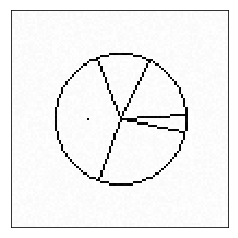

In [8]:
imshow(X_pie[0], cmap='Greys', interpolation='none')
ax = plt.gca()
ax.set_xticklabels('')
ax.set_yticklabels('')
from matplotlib.ticker import NullFormatter
ax.xaxis.set_major_formatter(NullFormatter())
ax.xaxis.set_ticks_position('none') 
ax.yaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_ticks_position('none') 
plt.savefig('../PAPER/gfx/pie_activation1.pdf', bbox_inches='tight', pad_inches=0)

In [15]:
X_pie_3D = np.stack((X_pie,)*3, -1)

In [78]:
for l in model_pie2.layers:
    print l.name

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
sequential_1


----- activations -----
(1, 100, 100, 64)
stored ../PAPER/gfx/ACTIVATIONMAPS/vgg_from_scratch_block1_conv1.pdf
----- activations -----
(1, 100, 100, 64)
stored ../PAPER/gfx/ACTIVATIONMAPS/vgg_from_scratch_block1_conv2.pdf
----- activations -----
----- activations -----
----- activations -----
(1, 50, 50, 128)
stored ../PAPER/gfx/ACTIVATIONMAPS/vgg_from_scratch_block2_conv1.pdf
----- activations -----
(1, 50, 50, 128)
stored ../PAPER/gfx/ACTIVATIONMAPS/vgg_from_scratch_block2_conv2.pdf
----- activations -----
----- activations -----
----- activations -----
(1, 25, 25, 256)
stored ../PAPER/gfx/ACTIVATIONMAPS/vgg_from_scratch_block3_conv1.pdf
----- activations -----
(1, 25, 25, 256)
stored ../PAPER/gfx/ACTIVATIONMAPS/vgg_from_scratch_block3_conv2.pdf
----- activations -----
(1, 25, 25, 256)
stored ../PAPER/gfx/ACTIVATIONMAPS/vgg_from_scratch_block3_conv3.pdf
----- activations -----
(1, 25, 25, 256)
stored ../PAPER/gfx/ACTIVATIONMAPS/vgg_from_scratch_block3_conv4.pdf
----- activations ----

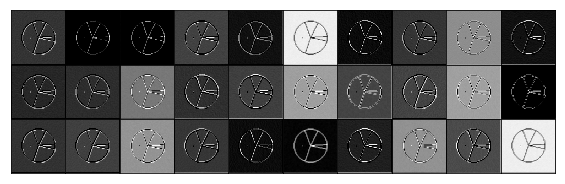

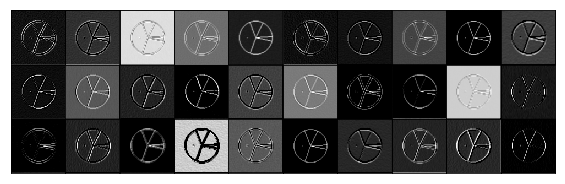

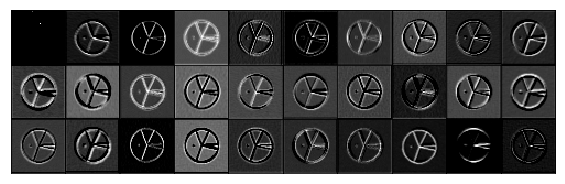

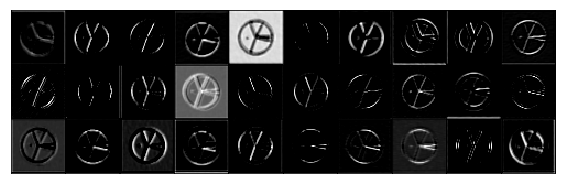

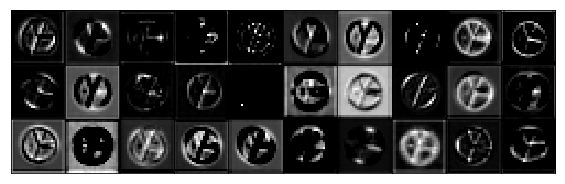

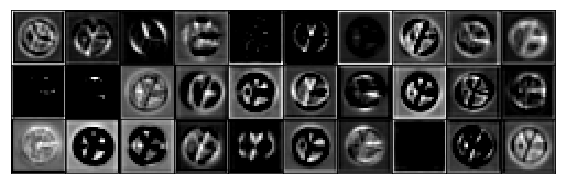

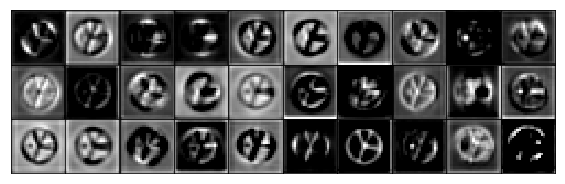

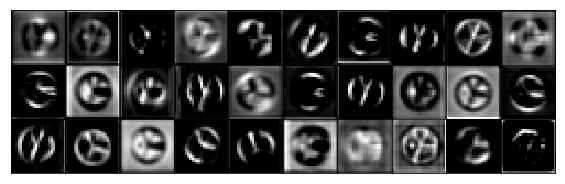

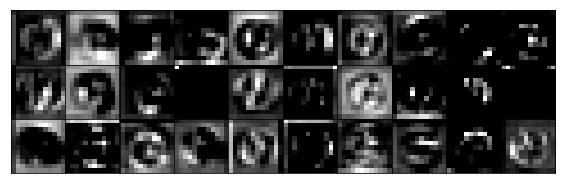

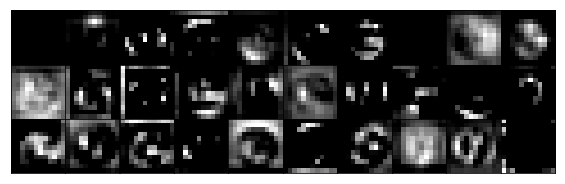

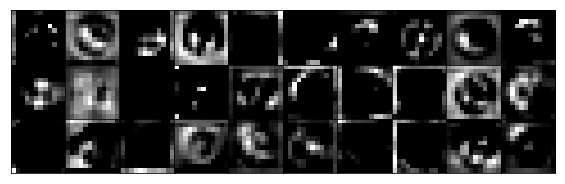

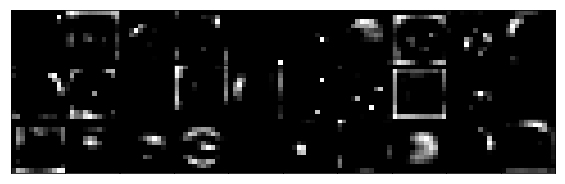

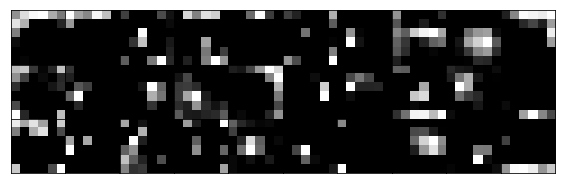

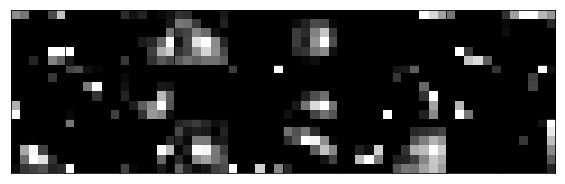

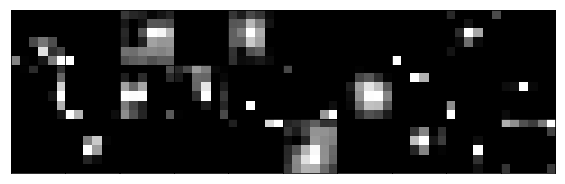

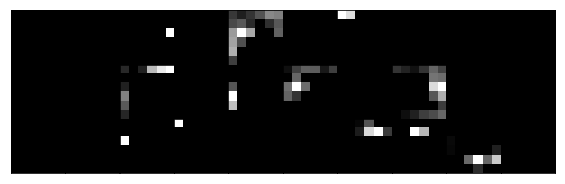

In [130]:
from matplotlib import gridspec

network = 'vgg_from_scratch'

for b in range(1,6):

    for c in range(1,5):
        layer_name = 'block'+str(b)+'_conv'+str(c)
        
        
        outputs_pie_conv2d_1 = get_activations(model_pie2, X_pie_3D.reshape(len(X_pie), 100, 100, 3), layer_name=layer_name, print_shape_only=True)

        fig = plt.figure(figsize=(10,3), facecolor='white')
        gs = gridspec.GridSpec(3, 10, width_ratios=[1,1,1,1,1,1,1,1,1,1], hspace=.0, wspace=-.2)
        if not outputs_pie_conv2d_1:
            continue
        for i in range(min(outputs_pie_conv2d_1[0].shape[3],30)):

            ax = fig.add_subplot(gs[i])

            ax = plt.gca()
            from matplotlib.ticker import NullFormatter
            ax.xaxis.set_major_formatter(NullFormatter())
            ax.xaxis.set_ticks_position('none') 
            ax.yaxis.set_major_formatter(NullFormatter())
            ax.yaxis.set_ticks_position('none') 
            plt.tight_layout()

            ax.set_xticklabels('')
            ax.set_yticklabels('')
   
            ax.imshow(outputs_pie_conv2d_1[0][0,:,:,i],cmap='gray')
        ofile = '../PAPER/gfx/ACTIVATIONMAPS/'+network+'_'+layer_name+'.pdf'
        plt.savefig(ofile)
        print 'stored', ofile

In [131]:
import keras.applications
model_pie1 = keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(100,100,3))

----- activations -----
(1, 100, 100, 64)
stored ../PAPER/gfx/ACTIVATIONMAPS/vgg_imagenet_block1_conv1.pdf
----- activations -----
(1, 100, 100, 64)
stored ../PAPER/gfx/ACTIVATIONMAPS/vgg_imagenet_block1_conv2.pdf
----- activations -----
----- activations -----
----- activations -----
(1, 50, 50, 128)
stored ../PAPER/gfx/ACTIVATIONMAPS/vgg_imagenet_block2_conv1.pdf
----- activations -----
(1, 50, 50, 128)
stored ../PAPER/gfx/ACTIVATIONMAPS/vgg_imagenet_block2_conv2.pdf
----- activations -----
----- activations -----
----- activations -----
(1, 25, 25, 256)
stored ../PAPER/gfx/ACTIVATIONMAPS/vgg_imagenet_block3_conv1.pdf
----- activations -----
(1, 25, 25, 256)
stored ../PAPER/gfx/ACTIVATIONMAPS/vgg_imagenet_block3_conv2.pdf
----- activations -----
(1, 25, 25, 256)
stored ../PAPER/gfx/ACTIVATIONMAPS/vgg_imagenet_block3_conv3.pdf
----- activations -----
(1, 25, 25, 256)
stored ../PAPER/gfx/ACTIVATIONMAPS/vgg_imagenet_block3_conv4.pdf
----- activations -----
(1, 12, 12, 512)
stored ../PAP

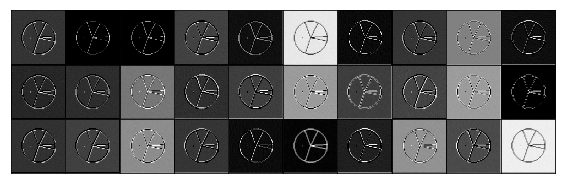

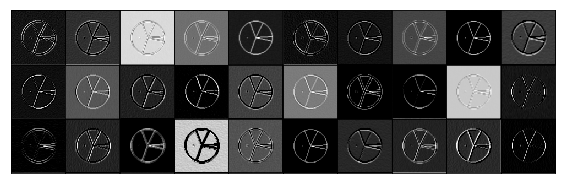

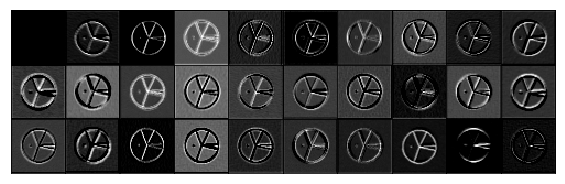

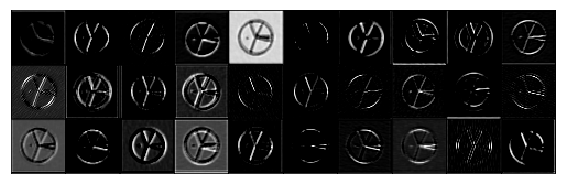

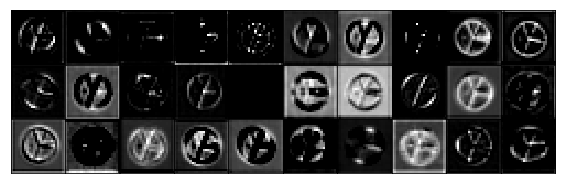

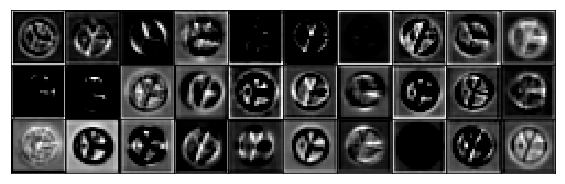

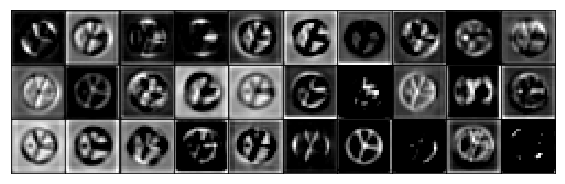

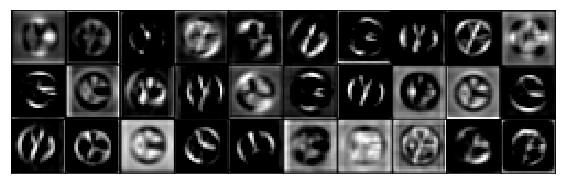

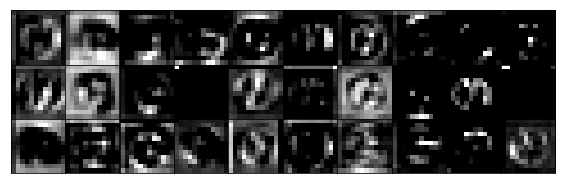

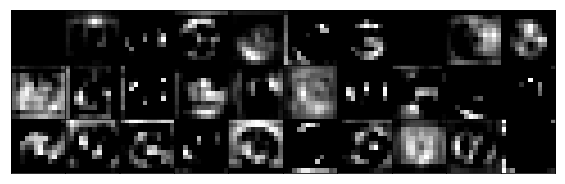

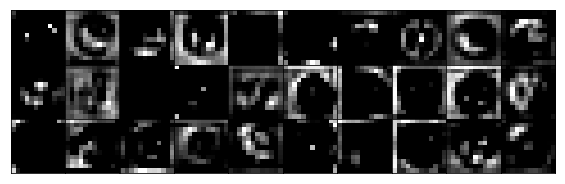

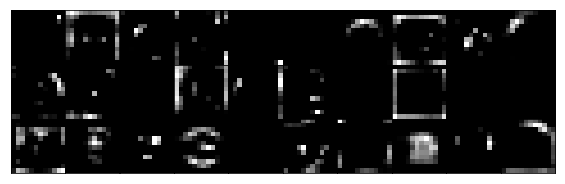

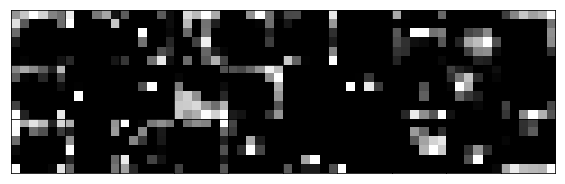

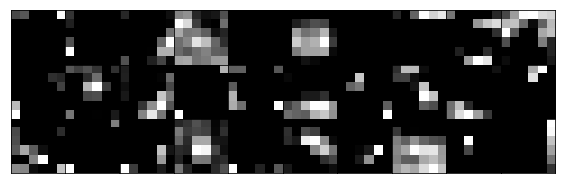

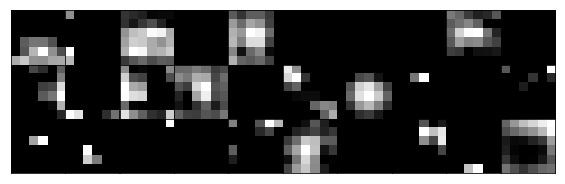

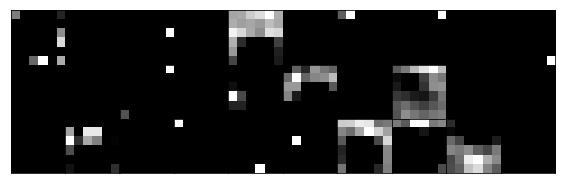

In [132]:
from matplotlib import gridspec

network = 'vgg_imagenet'

for b in range(1,6):

    for c in range(1,5):
        layer_name = 'block'+str(b)+'_conv'+str(c)
        
        
        outputs_pie_conv2d_1 = get_activations(model_pie1, X_pie_3D.reshape(len(X_pie), 100, 100, 3), layer_name=layer_name, print_shape_only=True)

        fig = plt.figure(figsize=(10,3), facecolor='white')
        gs = gridspec.GridSpec(3, 10, width_ratios=[1,1,1,1,1,1,1,1,1,1], hspace=.0, wspace=-.2)
        if not outputs_pie_conv2d_1:
            continue
        for i in range(min(outputs_pie_conv2d_1[0].shape[3],30)):

            ax = fig.add_subplot(gs[i])

            ax = plt.gca()
            from matplotlib.ticker import NullFormatter
            ax.xaxis.set_major_formatter(NullFormatter())
            ax.xaxis.set_ticks_position('none') 
            ax.yaxis.set_major_formatter(NullFormatter())
            ax.yaxis.set_ticks_position('none') 
            plt.tight_layout()

            ax.set_xticklabels('')
            ax.set_yticklabels('')
   
            ax.imshow(outputs_pie_conv2d_1[0][0,:,:,i],cmap='gray')
        ofile = '../PAPER/gfx/ACTIVATIONMAPS/'+network+'_'+layer_name+'.pdf'
        plt.savefig(ofile)
        print 'stored', ofile